# Inference and Evaluation (Baseline Model)


## 1. Setup & Installation


In [1]:
!pip install -q nnunetv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.5 MB/s eta 0:00:00


## 2. Environment Configuration


In [2]:
import os
from pathlib import Path
import shutil, nibabel as nib, json, pandas as pd, numpy as np
from scipy.spatial.distance import directed_hausdorff

# USER CONFIG
DATASET_ID = 2  # <--- ID of the dataset to use
DATASET_NAME = "BonnFCD_FLAIR"  # <--- Name of the dataset
CFG = "3d_fullres"  # <--- nnU-Net configuration (e.g., 2d, 3d_fullres)
FOLD = "2"   # <--- Fold number to use (0, 1, 2, 3, 4)
CHECKPOINT_NAME = "checkpoint_best.pth"  # <--- Checkpoint file name (e.g., checkpoint_best.pth)
TRAINER = "nnUNetTrainer"  # Your custom trainer name

DATASET_DIR = f"Dataset{DATASET_ID:03d}_{DATASET_NAME}"
INPUT_ROOT = Path("/kaggle/input/train-baseline-fold-2-dataset-1")  # <--- Root directory for input data
RAW_SRC = INPUT_ROOT / "nnUNet_raw_data" / DATASET_DIR

# nnU-Net environment variables
os.environ["nnUNet_raw"] = str(INPUT_ROOT / "nnUNet_raw_data")
os.environ["nnUNet_preprocessed"] = str(INPUT_ROOT / "nnUNet_preprocessed")
os.environ["nnUNet_results"] = str(INPUT_ROOT / "nnUNet_results")

print(f"✅ Environment configured for dataset: {DATASET_DIR}")
print(f"📁 Input root: {INPUT_ROOT}")
print(f"📁 Raw data: {RAW_SRC}")

# Use imagesTs and labelsTs directly from INPUT_ROOT
IMAGES_TS = RAW_SRC / "imagesTs"
LABELS_TS = RAW_SRC / "labelsTs"

print(f"📁 Test images: {IMAGES_TS}")
print(f"📁 Test labels: {LABELS_TS}")

# Verify folders exist
if not IMAGES_TS.exists():
    raise FileNotFoundError(f"imagesTs folder not found at {IMAGES_TS}")
if not LABELS_TS.exists():
    raise FileNotFoundError(f"labelsTs folder not found at {LABELS_TS}")

print(f"✅ Found {len(list(IMAGES_TS.glob('*.nii*')))} images")
print(f"✅ Found {len(list(LABELS_TS.glob('*.nii*')))} labels")

✅ Environment configured for dataset: Dataset002_BonnFCD_FLAIR
📁 Input root: /kaggle/input/train-baseline-fold-2-dataset-1
📁 Raw data: /kaggle/input/train-baseline-fold-2-dataset-1/nnUNet_raw_data/Dataset002_BonnFCD_FLAIR
📁 Test images: /kaggle/input/train-baseline-fold-2-dataset-1/nnUNet_raw_data/Dataset002_BonnFCD_FLAIR/imagesTs
📁 Test labels: /kaggle/input/train-baseline-fold-2-dataset-1/nnUNet_raw_data/Dataset002_BonnFCD_FLAIR/labelsTs
✅ Found 28 images
✅ Found 28 labels


Loading checkpoint: /kaggle/input/train-baseline-fold-2-dataset-1/nnUNet_results/Dataset002_BonnFCD_FLAIR/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_2/checkpoint_best.pth ...

✅ Training Status:
  - Last Completed Epoch: Unknown

📊 Latest Metrics (Epoch 86):
  - Training Loss:   -0.4731
  - Validation Loss: -0.3703
  - Validation Dice: 0.4830 (Mean Foreground)
✓ Training history saved to: /kaggle/working/inference_output_fold_2/training_history.csv
✓ Training history plot saved to: /kaggle/working/inference_output_fold_2/training_history.png


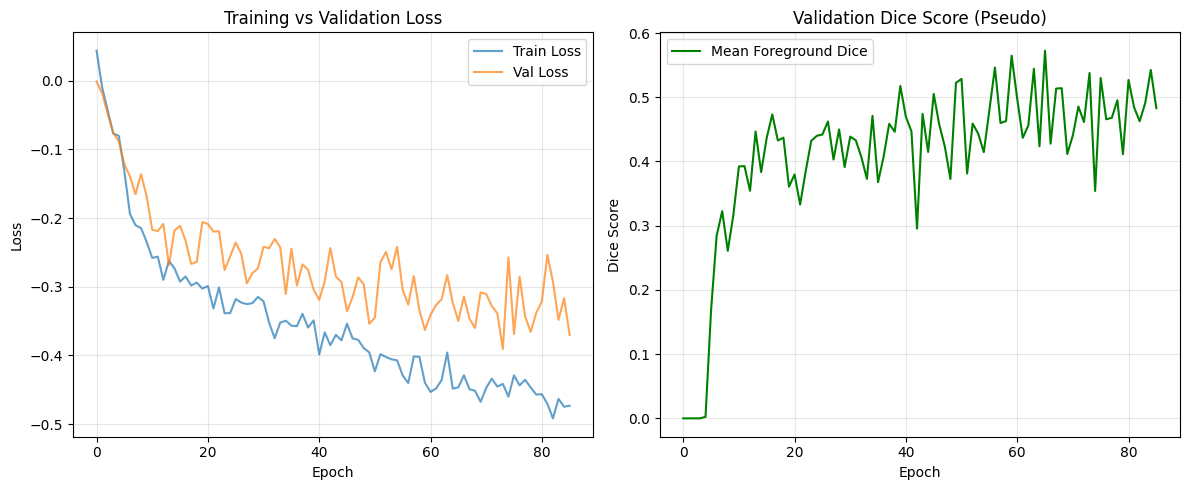

In [3]:
import torch
import matplotlib.pyplot as plt

# Where to save predictions
OUT = f"/kaggle/working/inference_output_fold_{FOLD}"  # change the output directory
os.makedirs(OUT, exist_ok=True)
OUT = Path(OUT)

# NNUNET RESULTS INPUT (User Input)
NNUNET_RESULTS_INPUT = INPUT_ROOT / "nnUNet_results"

CHECKPOINT_SOURCE = os.path.join(
    NNUNET_RESULTS_INPUT,
    "Dataset002_BonnFCD_FLAIR",
    "nnUNetTrainer__nnUNetPlans__3d_fullres",
    f"fold_{FOLD}",
    CHECKPOINT_NAME,
)

print(f"Loading checkpoint: {CHECKPOINT_SOURCE} ...")

try:
    # FIX: Added weights_only=False to bypass the new PyTorch 2.6 security check
    checkpoint = torch.load(CHECKPOINT_SOURCE, map_location='cpu', weights_only=False)

    # 1. Basic Info (Epoch)
    # Note: nnU-Net epochs start at 0, so if it says 999, you finished 1000 epochs.
    current_epoch = checkpoint.get('epoch', 'Unknown')
    print(f"\n✅ Training Status:")
    print(f"  - Last Completed Epoch: {current_epoch + 1 if isinstance(current_epoch, int) else current_epoch}")

    # 2. Extract Logging History
    if 'logging' in checkpoint:
        log = checkpoint['logging']
        
        # Extract lists
        train_losses = log.get('train_losses', [])
        val_losses = log.get('val_losses', [])
        mean_dice = log.get('mean_fg_dice', []) # Pseudo dice on validation set
        
        if len(train_losses) > 0:
            print(f"\n📊 Latest Metrics (Epoch {len(train_losses)}):")
            print(f"  - Training Loss:   {train_losses[-1]:.4f}")
            print(f"  - Validation Loss: {val_losses[-1]:.4f}")
            print(f"  - Validation Dice: {mean_dice[-1]:.4f} (Mean Foreground)")
            
            # --- Save History to CSV ---
            # Create a dictionary since lengths might differ slightly if crashed, usually they match
            min_len = min(len(train_losses), len(val_losses), len(mean_dice))
            history_data = {
                "Epoch": list(range(min_len)),
                "Train_Loss": train_losses[:min_len],
                "Val_Loss": val_losses[:min_len],
                "Val_Dice": mean_dice[:min_len]
            }
            df_history = pd.DataFrame(history_data)
            
            history_csv_path = Path(OUT) / "training_history.csv"
            df_history.to_csv(history_csv_path, index=False)
            print(f"✓ Training history saved to: {history_csv_path}")

            # --- Plotting and Saving ---
            plt.figure(figsize=(12, 5))
            
            # Loss Plot
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train Loss', alpha=0.7)
            plt.plot(val_losses, label='Val Loss', alpha=0.7)
            plt.title("Training vs Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Dice Plot
            plt.subplot(1, 2, 2)
            plt.plot(mean_dice, label='Mean Foreground Dice', color='green')
            plt.title("Validation Dice Score (Pseudo)")
            plt.xlabel("Epoch")
            plt.ylabel("Dice Score")
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            # Save Plot
            history_plot_path = Path(OUT) / "training_history.png"
            plt.savefig(history_plot_path)
            print(f"✓ Training history plot saved to: {history_plot_path}")
            
            plt.show()
        else:
            print("⚠ 'logging' key found but lists are empty.")
            
    else:
        print("⚠ 'logging' key not found in checkpoint. Available keys:", checkpoint.keys())

except FileNotFoundError:
    print(f"❌ Error: File not found at {CHECKPOINT_SOURCE}")
except Exception as e:
    print(f"❌ Error reading checkpoint: {e}")

## 3. Inference


In [4]:
INP = IMAGES_TS
# OUT = Path(f"/kaggle/working/preds_D{DATASET_ID:03d}_{CFG}_fold{FOLD}_best")
# OUT.mkdir(parents=True, exist_ok=True)

print("🔍 Running inference ...")
print(f"   Input: {INP}")
print(f"   Output: {OUT}")
print(f"   Trainer: {TRAINER}")
print(f"   Fold: {FOLD}")

!nnUNetv2_predict -i "$INP" -o "$OUT" -d "$DATASET_ID" -c "$CFG" -f "$FOLD" -tr "$TRAINER" -chk "$CHECKPOINT_NAME"
print(f"✅ Predictions saved to: {OUT}")

🔍 Running inference ...
   Input: /kaggle/input/train-baseline-fold-2-dataset-1/nnUNet_raw_data/Dataset002_BonnFCD_FLAIR/imagesTs
   Output: /kaggle/working/inference_output_fold_2
   Trainer: nnUNetTrainer
   Fold: 2

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 28 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 28 cases that I would like to predict

Predicting sub-00004:
perform_everything_on_device: True
100%|███████████████████████████████████████████| 27/27 [00:56<00:00,  2.08s/it]
sending off prediction to background worker for resampling and export
done w

## 4. Evaluation Metrics


In [5]:
def dice_score(gt, pred):
    intersection = np.sum((gt > 0) & (pred > 0))
    total = np.sum(gt > 0) + np.sum(pred > 0)
    return 2 * intersection / total if total > 0 else 1.0

def iou_score(gt, pred):
    intersection = np.sum((gt > 0) & (pred > 0))
    union = np.sum((gt > 0) | (pred > 0))
    return intersection / union if union > 0 else 1.0

def precision_recall_f1(gt, pred):
    tp = np.sum((gt > 0) & (pred > 0))
    fp = np.sum((gt == 0) & (pred > 0))
    fn = np.sum((gt > 0) & (pred == 0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 1.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

results = []
print(f"\n🔎 Looking for labels in: {LABELS_TS}")
print(f"🔎 Looking for predictions in: {OUT}")

label_files = list(sorted(LABELS_TS.glob("*.nii*")))
pred_files = list(sorted(OUT.glob("*.nii*")))

print(f"\n📋 Found {len(label_files)} label files")
print(f"📋 Found {len(pred_files)} prediction files")

if len(label_files) == 0:
    print("❌ ERROR: No label files found!")
if len(pred_files) == 0:
    print("❌ ERROR: No prediction files found!")

for lbl_file in label_files:
    stem = lbl_file.stem.replace('.nii', '')  # Handle both .nii and .nii.gz

    # Try to find matching prediction with different extensions
    pred_file = None
    for ext in ['.nii', '.nii.gz']:
        potential_pred = OUT / f"{stem}{ext}"
        if potential_pred.exists():
            pred_file = potential_pred
            break

    if pred_file is None:
        print(f"⚠️  No prediction found for {stem}")
        continue

    print(f"✓ Processing {stem}")
    gt = nib.load(str(lbl_file)).get_fdata()
    pred = nib.load(str(pred_file)).get_fdata()

    dice = dice_score(gt, pred)
    iou = iou_score(gt, pred)
    prec, rec, f1 = precision_recall_f1(gt, pred)

    results.append({
        "Case": stem,
        "Dice": dice,
        "IoU": iou,
    })


🔎 Looking for labels in: /kaggle/input/train-baseline-fold-2-dataset-1/nnUNet_raw_data/Dataset002_BonnFCD_FLAIR/labelsTs
🔎 Looking for predictions in: /kaggle/working/inference_output_fold_2

📋 Found 28 label files
📋 Found 28 prediction files
✓ Processing sub-00004
✓ Processing sub-00006
✓ Processing sub-00009
✓ Processing sub-00020
✓ Processing sub-00032
✓ Processing sub-00034
✓ Processing sub-00043
✓ Processing sub-00048
✓ Processing sub-00061
✓ Processing sub-00062
✓ Processing sub-00064
✓ Processing sub-00066
✓ Processing sub-00074
✓ Processing sub-00092
✓ Processing sub-00095
✓ Processing sub-00099
✓ Processing sub-00100
✓ Processing sub-00103
✓ Processing sub-00107
✓ Processing sub-00108
✓ Processing sub-00121
✓ Processing sub-00125
✓ Processing sub-00128
✓ Processing sub-00134
✓ Processing sub-00136
✓ Processing sub-00142
✓ Processing sub-00144
✓ Processing sub-00145


## 5. Results Analysis


In [6]:
if len(results) == 0:
    print("\n❌ ERROR: No results computed. Check that predictions match labels.")
else:
    df = pd.DataFrame(results).round(4)
    df.to_csv("/kaggle/working/full_metrics_per_case.csv", index=False)

    print(f"\n{df.to_string()}")
    print("\n" + "="*60)
    print("📊 SUMMARY STATISTICS")
    print("="*60)
    print(f"📊 Mean Dice:       {df['Dice'].mean():.4f}")
    print(f"📊 Mean IoU:        {df['IoU'].mean():.4f}")
    print("="*60)
    print("💾 Saved → /kaggle/working/full_metrics_per_case.csv")


         Case    Dice     IoU
0   sub-00004  0.0000  0.0000
1   sub-00006  0.0006  0.0003
2   sub-00009  0.0000  0.0000
3   sub-00020  0.6151  0.4441
4   sub-00032  0.2360  0.1338
5   sub-00034  0.0000  0.0000
6   sub-00043  0.0000  0.0000
7   sub-00048  0.0000  0.0000
8   sub-00061  0.6726  0.5067
9   sub-00062  0.0000  0.0000
10  sub-00064  0.4370  0.2796
11  sub-00066  0.0000  0.0000
12  sub-00074  0.0000  0.0000
13  sub-00092  0.6165  0.4456
14  sub-00095  0.0000  0.0000
15  sub-00099  0.1766  0.0969
16  sub-00100  0.0000  0.0000
17  sub-00103  0.0000  0.0000
18  sub-00107  0.0000  0.0000
19  sub-00108  0.0000  0.0000
20  sub-00121  0.0000  0.0000
21  sub-00125  0.4632  0.3014
22  sub-00128  0.7320  0.5773
23  sub-00134  0.2622  0.1509
24  sub-00136  0.5975  0.4261
25  sub-00142  0.3007  0.1769
26  sub-00144  0.4573  0.2965
27  sub-00145  0.6081  0.4368

📊 SUMMARY STATISTICS
📊 Mean Dice:       0.2206
📊 Mean IoU:        0.1526
💾 Saved → /kaggle/working/full_metrics_per_case.csv
